In [1]:
import pandas as pd  # For dataset loading and manipulation
import numpy as np  # For arrays operation
from collections import Counter  # To count labels inside of lists
import matplotlib.pyplot as plt

In [2]:
# Load the hr dataset, change its path.
df = pd.read_pickle(
    r"D:\Datasets Creation\Datasets\TimeWaveFormg GP Datasets Revised Final\hr.pickle"
)
df.head()

,ts,name,faults
0,"[[0.000167964, -5.34659e-05, 1.28447e-05, 9.03...",9.1120 C Hot Water Pump,"[[BearingFault, motor], [XC, machine], [Bearin..."
1,"[[0.009780156, 0.014624815, 0.019440233, 0.020...",Air RecFan 1.12302,"[[Looseness, machine], [Misalignment, machine]..."
2,"[[0.001560547, 0.001073043, -2.44838e-05, -0.0...",Air RecFan 1.12302,"[[Looseness, machine], [Misalignment, machine]..."
3,"[[-0.002804407, -0.001306111, 0.001502491, 0.0...",Air RecFan 1.12402A,"[[Looseness, machine], [Misalignment, machine]..."
4,"[[0.000500389, 0.00026631, -6.22153e-05, -0.00...",Vacuum Pump 5.1302,"[[Misalignment, machine], [Looseness, machine]..."


In [3]:
len(df)

232

In [4]:
df["faults"].explode().value_counts()

faults
[Misalignment, machine]          222
[Flow, machine]                   90
[BearingFault, machine]           72
[BearingFault, motor]             68
[LXC, machine]                    56
[Coupling, machine]               53
[BearingLubrication, machine]     38
[SoftFoot, motor]                 37
[Looseness, machine]              33
[XC, machine]                     32
[BaseProblems, motor]             25
[Unbalance, machine]              24
[BeltProblem, machine]            23
[BearingLubrication, motor]       21
[AirGap, motor]                   21
[NAF]                             19
[BearingWear, machine]            19
[BaseProblems, machine]           17
[ElectricalProblem, motor]        17
[LXC, motor]                      12
[CockedBearing, machine]           9
[XC, motor]                        6
[BearingWear, motor]               5
[Looseness, motor]                 3
[SoftFoot, machine]                3
[MotorCoolingFan, motor]           2
[Rubbing, machine]             

In [5]:
# Create query lists that we will use to get the faults we want from the dataframe.
###### Change the names in faults_to_take if you want to include/exclude faults or experiment with other faults ######
faults_to_take = ["BearingFault", "BearingWear", "BearingLubrication", "Flow"]
locations = ["machine", "motor"]
query_strings = []
for fault in faults_to_take:
    for location in locations:
        query_strings.append([fault, location])
query_strings

[['BearingFault', 'machine'],
 ['BearingFault', 'motor'],
 ['BearingWear', 'machine'],
 ['BearingWear', 'motor'],
 ['BearingLubrication', 'machine'],
 ['BearingLubrication', 'motor'],
 ['Flow', 'machine'],
 ['Flow', 'motor']]

In [6]:
# The following are dataframe preprocessing steps to create the arrays we will use in the training.
df["motor_bearing"] = 0
df["machine_bearing"] = 0

for index, row in df.iterrows():
    faults = row["faults"]

    for query in query_strings:
        if query in faults:
            if "motor" in query:
                df.at[index, "motor_bearing"] = 1

            elif "machine" in query:
                df.at[index, "machine_bearing"] = 1

In [7]:
# ts_list contains the actual time series values, labels_list is a list of lists, each sublist has two values [motor_label, machine_label]
ts_list = df["ts"].to_list()
labels_list = df.apply(
    lambda row: [row["motor_bearing"], row["machine_bearing"]], axis=1
)

In [8]:
def separate_data(ts_list, labels_list, split_type="by_bearing"):

    bearing_ts = []
    bearing_labels = []

    if split_type == "by_bearing":

        for i in range(len(ts_list)):
            ts_all = ts_list[i]

            motor_label = labels_list[i][0]
            machine_label = labels_list[i][1]

            motor_bearing_1_ts = ts_all[:3]
            motor_bearing_2_ts = ts_all[3:6]

            machine_bearing_1_ts = ts_all[6:9]
            machine_bearing_2_ts = ts_all[9:12]

            bearing_ts.append(motor_bearing_1_ts)
            bearing_labels.append(motor_label)

            bearing_ts.append(motor_bearing_2_ts)
            bearing_labels.append(motor_label)

            bearing_ts.append(machine_bearing_1_ts)
            bearing_labels.append(machine_label)

            bearing_ts.append(machine_bearing_2_ts)
            bearing_labels.append(machine_label)

    elif split_type == "by_machine":

        for i in range(len(ts_list)):
            ts_all = ts_list[i]

            motor_label = labels_list[i][0]
            machine_label = labels_list[i][1]

            motor_bearings = ts_all[:6]
            machine_bearings = ts_all[6:]

            bearing_ts.append(motor_bearings)
            bearing_labels.append(motor_label)

            bearing_ts.append(machine_bearings)
            bearing_labels.append(machine_label)

    return bearing_ts, bearing_labels

In [9]:
split_ts, split_labels = separate_data(
    ts_list, labels_list, split_type="by_machine"
)  # CHANGE SPLIT TYPE TO BE by_bearing OR by_machine

In [10]:
def GetFFT(ts):
    return np.abs(np.fft.rfft(ts * np.hanning(len(ts))))[:-1] * 2


# np.apply_along_axis(GetFFT, 1, split_ts[292])

In [11]:
def getWindowedData(ts, label, window_length=1024, overlap=0.1, fft=False):
    """Will return an array of shape (Number of windows x Number of channels x Length)
    The overlap value here is a percentage, i.e. for a value of 0.1, each two successive time series will 10% common values
    For no overlap, set overlap = 0 when calling the function"""

    ts_no_nans = ts[
        :, ~np.any(np.isnan(ts), axis=0)
    ]  # Index the time series to remove NaNs
    step_size = int(window_length * (1 - overlap))

    windowed_ts_list = list()
    windowed_labels = []

    for i in range(0, ts_no_nans.shape[1] - window_length + 1, step_size):
        start_index = i
        end_index = i + window_length
        if fft == True:
            windowed_ts_list.append(
                np.apply_along_axis(GetFFT, 1, ts_no_nans[:, start_index:end_index])
            )
        else:
            windowed_ts_list.append(ts_no_nans[:, start_index:end_index])

        windowed_labels.append(label)

    windowed_ts_array = np.array(windowed_ts_list)
    windowed_labels = np.array(windowed_labels)

    return windowed_ts_array, windowed_labels

In [12]:
# Rename variables for more clarity
ts_list = split_ts
labels_list = split_labels

In [13]:
# Import tsai
from tsai.all import *

computer_setup()

f:\Anaconda\envs\ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


os              : Windows-10-10.0.19045-SP0
python          : 3.8.18
tsai            : 0.3.8
fastai          : 2.7.13
fastcore        : 1.5.29
torch           : 2.1.2
device          : 1 gpu (['NVIDIA GeForce GTX 1650 Ti'])
cpu cores       : 6
threads per cpu : 2
RAM             : 15.87 GB
GPU memory      : [4.0] GB


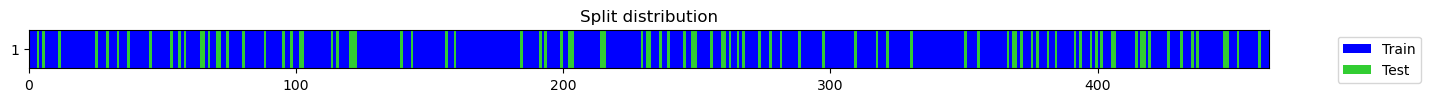

((#372) [312,356,50,81,408,291,424,167,392,370...],
 (#92) [262,330,391,277,259,67,267,265,122,317...])

In [45]:
# Shuffle and do training and testing splitting.
# REMEMBER! Make sure to NOT include two windows of the same time series in training and testing simultaneously.
splits = get_splits(
    np.array(labels_list), valid_size=0.2, random_state=23, shuffle=True
)
splits

In [46]:
# See counts of each label in training and testing.
print(Counter(list(np.array(split_labels)[splits[0]])))  # Training count
print(Counter(list(np.array(split_labels)[splits[1]])))  # Testing count

Counter({0: 187, 1: 185})
Counter({0: 46, 1: 46})


In [47]:
train_sample_indices = list(splits[0])
test_sample_indices = list(splits[1])

In [48]:
# Now that we made each time series in its container (train, test), we can now apply the sliding window safely.

window_length = 1024
overlap = 0.2
fft = False

X_train = []
y_train = []
X_test = []
y_test = []

for index in train_sample_indices:
    ts = ts_list[index]
    label = labels_list[index]
    data_pairs = getWindowedData(
        ts, label=label, window_length=window_length, overlap=overlap, fft=fft
    )
    X_train.append(data_pairs[0])
    y_train.append(data_pairs[1])

# Iterate over the test samples
for index in test_sample_indices:
    ts = ts_list[index]
    label = labels_list[index]
    data_pairs = getWindowedData(
        ts, label=label, window_length=window_length, overlap=overlap, fft=fft
    )
    X_test.append(data_pairs[0])
    y_test.append(data_pairs[1])

# Concatenate the train and test sets
X_train_arr = np.concatenate(X_train, axis=0)
y_train_arr = np.concatenate(y_train, axis=0)
X_test_arr = np.concatenate(X_test, axis=0)
y_test_arr = np.concatenate(y_test, axis=0)

In [49]:
# Let's count the distibutions and see again.
print(Counter(list(y_train_arr)))
print(Counter(list(y_test_arr)))

Counter({1: 1018, 0: 923})
Counter({1: 257, 0: 206})


In [50]:
X, y, splits = combine_split_data([X_train_arr, X_test_arr], [y_train_arr, y_test_arr])

In [51]:
tfms = [None, [TSStandardize(by_var=True), Categorize()]]
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(
    X,
    y,
    splits=splits,
    tfms=tfms,
    shuffle_train=True,
    batch_tfms=batch_tfms,
    bs=[64, 256],
)

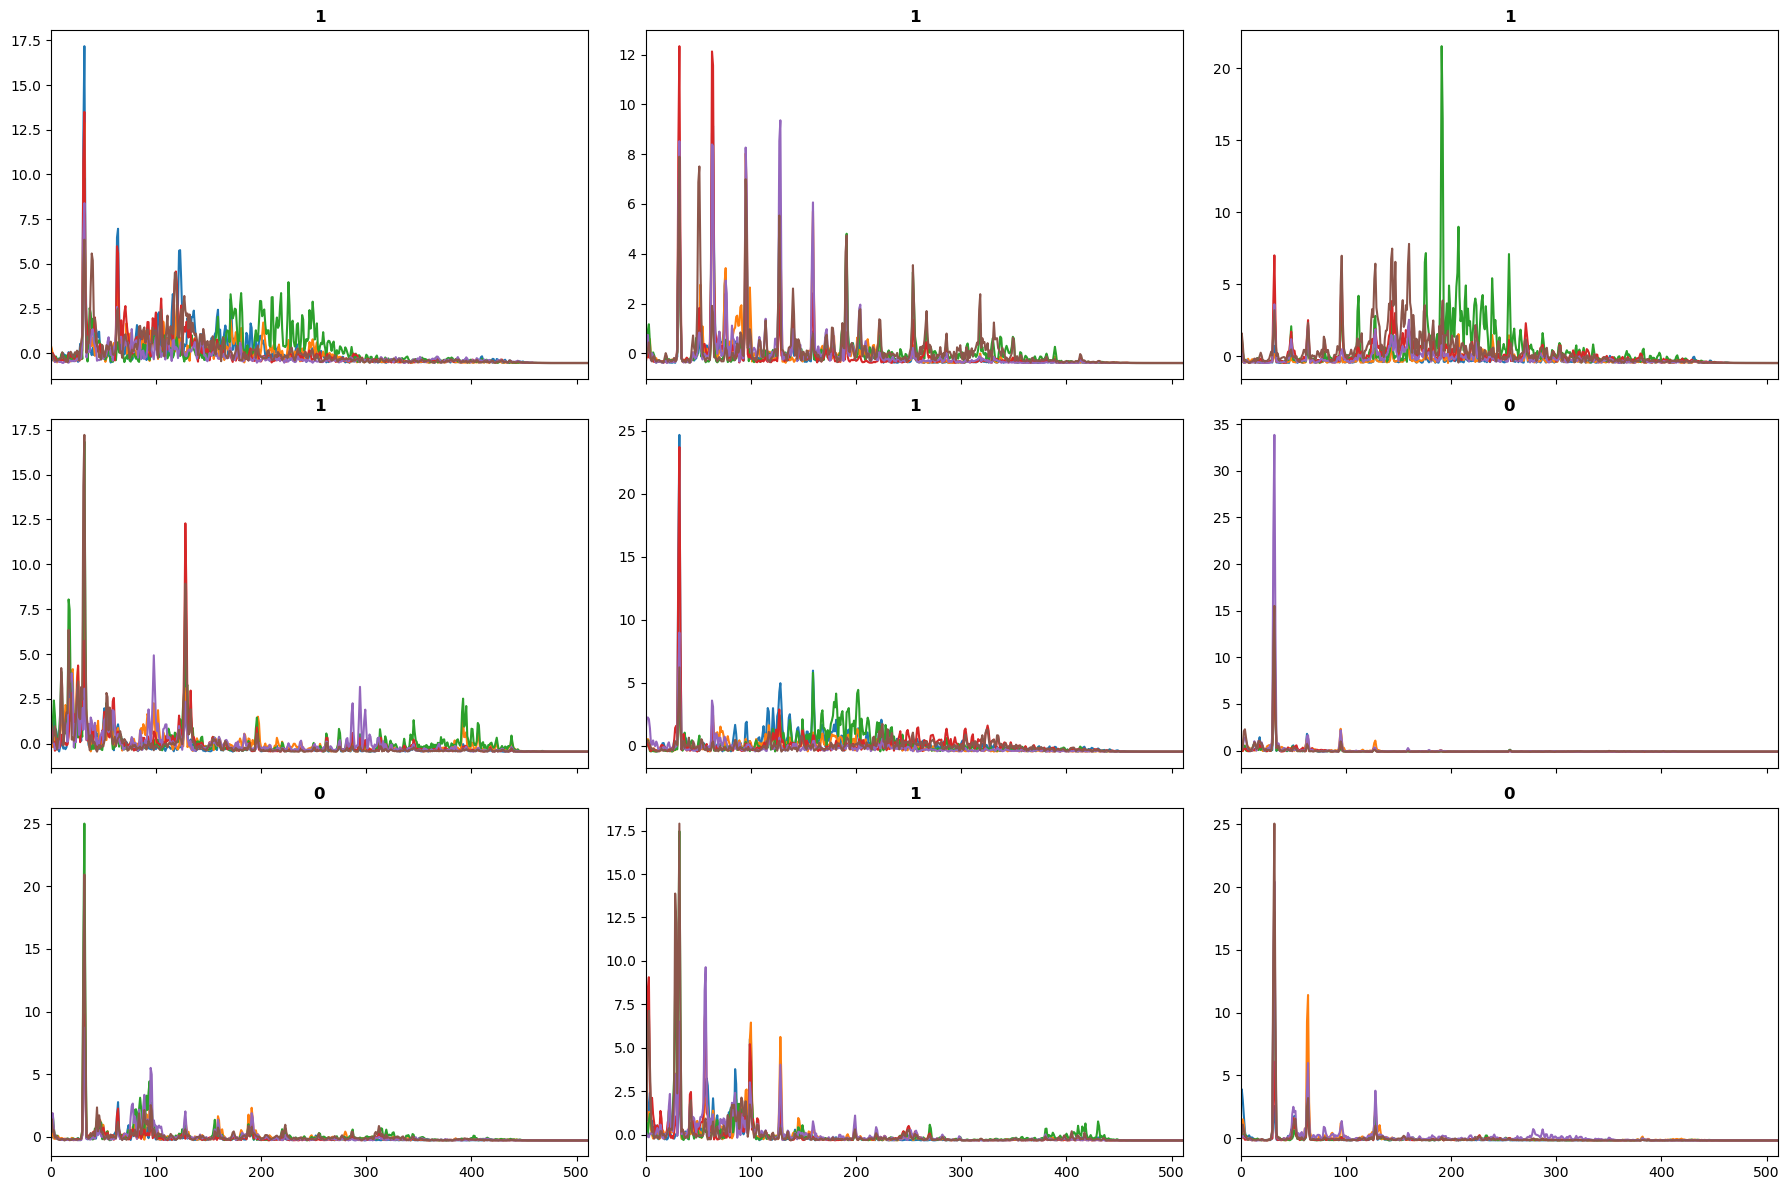

In [52]:
dls.show_batch(sharex=True)

In [53]:
model = xresnet1d18(dls.vars, dls.c)
learn = Learner(dls, model, metrics=[accuracy, Precision(), Recall(), F1Score()])

In [54]:
learn.fit_one_cycle(15, lr_max=learn.lr_find(), cbs=[PredictionDynamics()])

KeyboardInterrupt: 

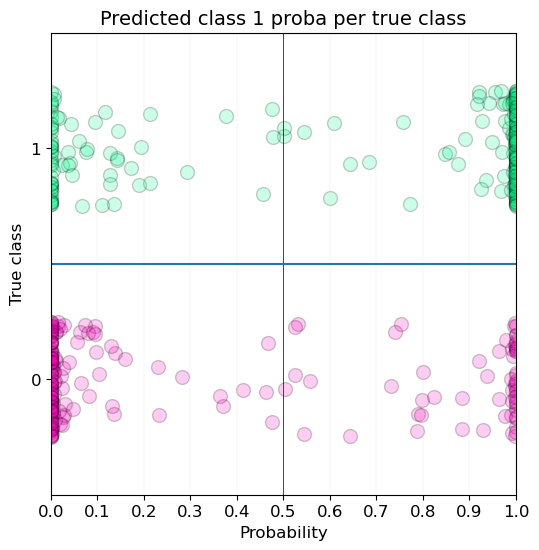

In [ ]:
learn.show_probas()

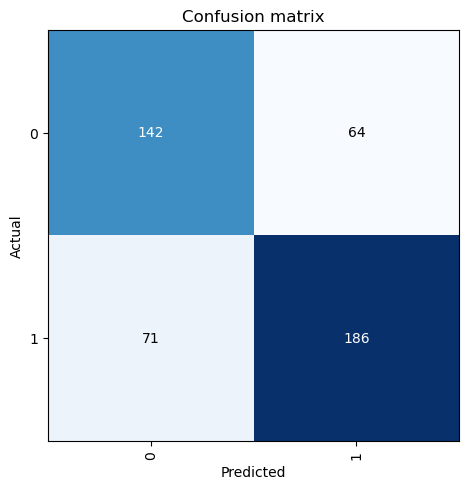

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
valid_dl = dls.valid
valid_probas, valid_targets, valid_preds = learn.get_preds(
    dl=valid_dl, with_decoded=True
)
valid_probas, valid_targets, valid_preds

(tensor([[9.9990e-01, 1.0045e-04],
         [9.9997e-01, 3.3379e-05],
         [9.9996e-01, 3.6579e-05],
         [9.9997e-01, 2.6909e-05],
         [9.9997e-01, 2.5242e-05],
         [9.9997e-01, 3.4161e-05],
         [9.9988e-01, 1.2363e-04],
         [9.9806e-01, 1.9373e-03],
         [9.9273e-01, 7.2720e-03],
         [9.9954e-01, 4.5901e-04],
         [8.9708e-01, 1.0292e-01],
         [9.7347e-01, 2.6525e-02],
         [9.9235e-01, 7.6474e-03],
         [9.3718e-01, 6.2824e-02],
         [2.0974e-01, 7.9026e-01],
         [1.1593e-01, 8.8407e-01],
         [3.5589e-01, 6.4411e-01],
         [2.0581e-04, 9.9979e-01],
         [9.8910e-01, 1.0902e-02],
         [8.6197e-01, 1.3803e-01],
         [9.0483e-01, 9.5173e-02],
         [9.2692e-01, 7.3076e-02],
         [1.2398e-03, 9.9876e-01],
         [2.0996e-02, 9.7900e-01],
         [5.5242e-04, 9.9945e-01],
         [5.6583e-04, 9.9943e-01],
         [1.5713e-05, 9.9998e-01],
         [1.3149e-04, 9.9987e-01],
         [2.1672e-05

In [ ]:
positive_probs = valid_probas[:, 1]

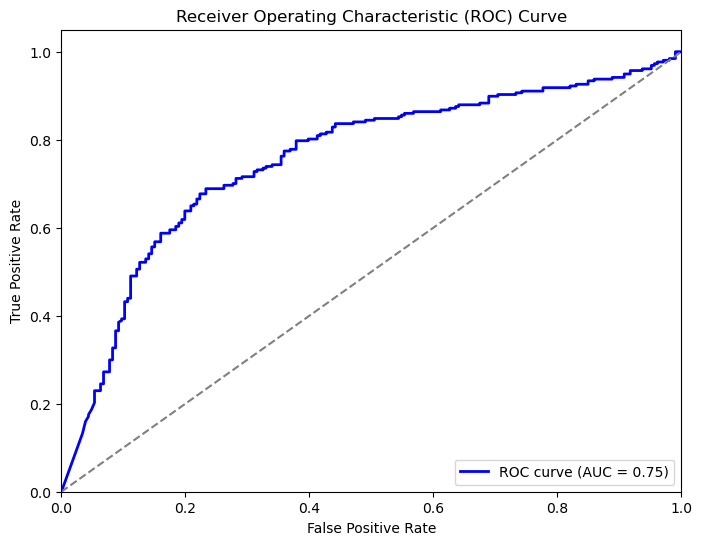

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Draw ROC curve to help us adjust the threshold to a better value.
fpr, tpr, thresholds = roc_curve(valid_targets, positive_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# We can calculate the optimum value for the threshold from the following code:
youden_index = tpr - fpr
optimal_threshold = thresholds[np.argmax(youden_index)]
print("Optimal threshold:", optimal_threshold)

Optimal threshold: 0.84666127


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

positive_probs = valid_probas[:, 1]

threshold = optimal_threshold  ###Adjust threshold if required. Use the optimal one found in the previous cell.

valid_preds_adjusted = (positive_probs > threshold).long()

accuracy = accuracy_score(valid_targets, valid_preds_adjusted)
precision = precision_score(valid_targets, valid_preds_adjusted)
recall = recall_score(valid_targets, valid_preds_adjusted)
f1 = f1_score(valid_targets, valid_preds_adjusted)

print("Adjusted Threshold Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Adjusted Threshold Metrics:
Accuracy: 0.7214
Precision: 0.7857
Recall: 0.6848
F1 Score: 0.7318


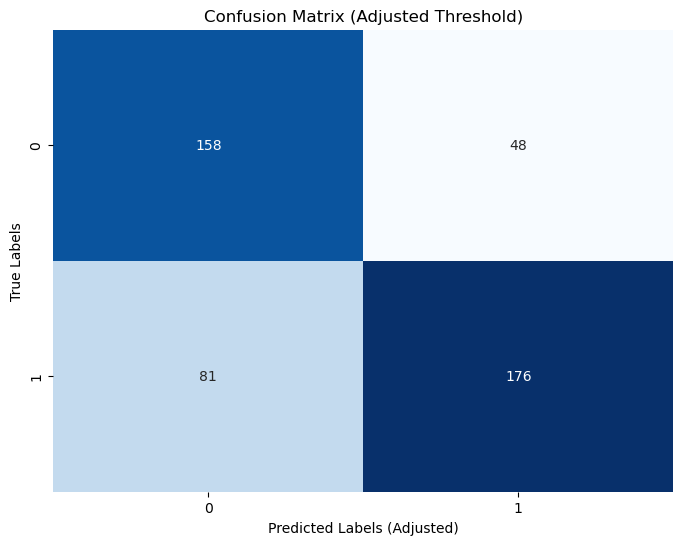

In [ ]:
# Plot confusion matrix after adjsuting the threshold
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(valid_targets, valid_preds_adjusted)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels (Adjusted)")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Adjusted Threshold)")
plt.show()